# 실거래가 예측

#### 참고
- [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM y CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)

In [1]:
import plotly.graph_objects as go

from ta.trend import MACD
from ta.momentum import StochasticOscillator

import numpy as np
import pandas as pd
from pykrx import stock
from pykrx import bond
from time import sleep

from datetime import datetime
from datetime import timedelta
import os
import time
from plotly.subplots import make_subplots
import glob


from xgboost import plot_importance, plot_tree


from sklearn.model_selection import train_test_split # train/test set 분할


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt # 시각화


# 시계열
# from xgboost
import xgboost as xgb
import lightgbm as lgb
# import lightgbm as lgb

import warnings
warnings.filterwarnings(action='ignore')

## 함수

In [3]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
#     df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df.drop(['corp_name', 'market','ticker', 'date','close'],axis=1)

    
#     X = df[['hour','dayofweek','quarter','month','year',
#            'dayofyear','dayofmonth','weekofyear']]

    if label:
        y = df[label]
        return X, y
    return X

def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

## 보조지표 파일 로드

In [4]:
df_raw_total = pd.read_csv('df_raw_total.csv', dtype = {'ticker':str})

In [5]:
model_df = df_raw_total[df_raw_total['corp_name'] == '삼성전자'].reset_index(drop = True)


model_df['date'] = pd.to_datetime(model_df['date'])

model_df = model_df[model_df['date'] > '2023-01-01']
data_train  = model_df[model_df['date'] < '2023-10-01']
data_test  = model_df[model_df['date'] >=  '2023-10-01']

In [6]:
X_train, y_train = create_features(data_train, label='close')
X_test, y_test = create_features(data_test, label='close')

In [7]:

params = {'n_estimators':100, 
          'learning_rate':0.08, 
          'gamma':0, 
          'subsample':0.75,
          'colsample_bytree':1, 
          'max_depth':7}

reg = xgb.XGBRegressor(params = params,
                       num_boost_round = 500, 
                       early_stopping_rounds=50,
                       n_estimators=1000)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],

       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_boost_round=500, num_parallel_tree=None, ...)

In [8]:
data_test['number_Prediction'] = reg.predict(X_test)
data_all = pd.concat([data_train, data_test], sort=False)

In [9]:
data_test[['close', 'number_Prediction']]

,close,number_Prediction
1296,67500,67436.195312
1297,66700,67263.968750
1298,66000,67234.062500
1299,66400,67165.281250
1300,68200,68626.976562
1301,68900,69076.117188
1302,68000,68341.742188
1303,67300,67899.820312
1304,69400,68647.078125
1305,70500,70376.507812


In [10]:
test_pred_xgb = reg.predict(X_test)

test_rmse_xgb = round(mean_squared_error(y_test, test_pred_xgb)**0.5,0)

test_mae_xgb = round(mean_absolute_error(y_test, test_pred_xgb),0)

test_mape_xgb = round(MAPE(y_test, test_pred_xgb),3)

test_r_squre_xgb = round(r2_score(y_test, test_pred_xgb),3)

In [11]:
test_mape_xgb

0.66

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

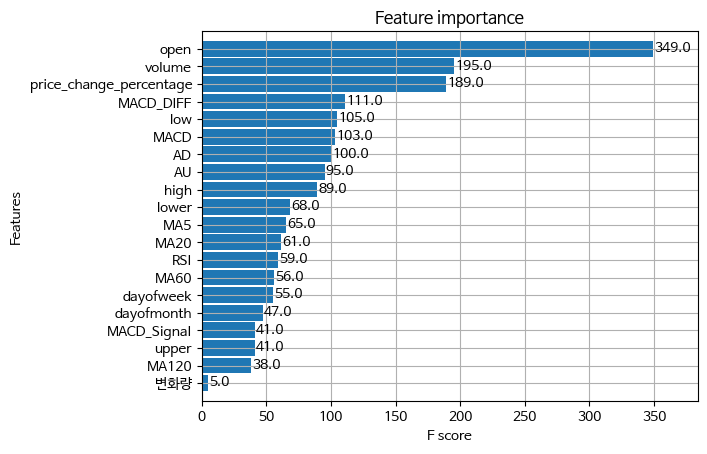

In [12]:
plot_importance(reg, height=0.9)

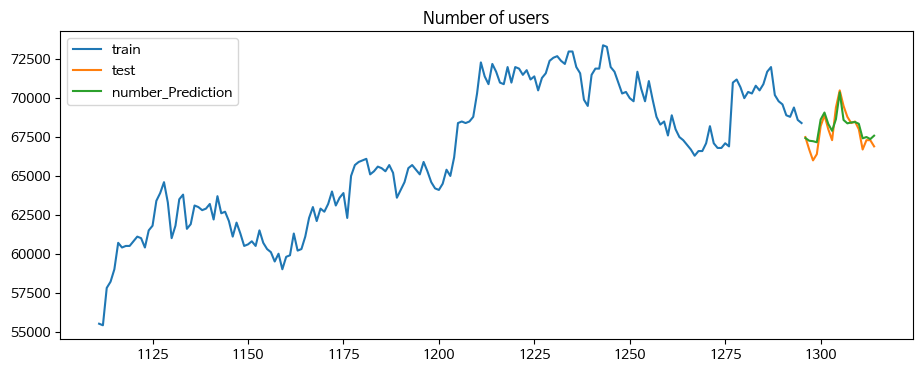

In [13]:
fig, ax = plt.subplots(figsize=(11, 4))
data_train['close'].plot(ax=ax, label='train')
data_test['close'].plot(ax=ax, label='test')
data_test['number_Prediction'].plot(ax=ax, label='number_Prediction')
ax.set_title('Number of users')
ax.legend();

## 한계

- [(칼럼) 딥러닝 초보들이 흔히하는 실수 : 주식가격 예측 AI](https://codingapple.com/unit/deep-learning-stock-price-ai/)